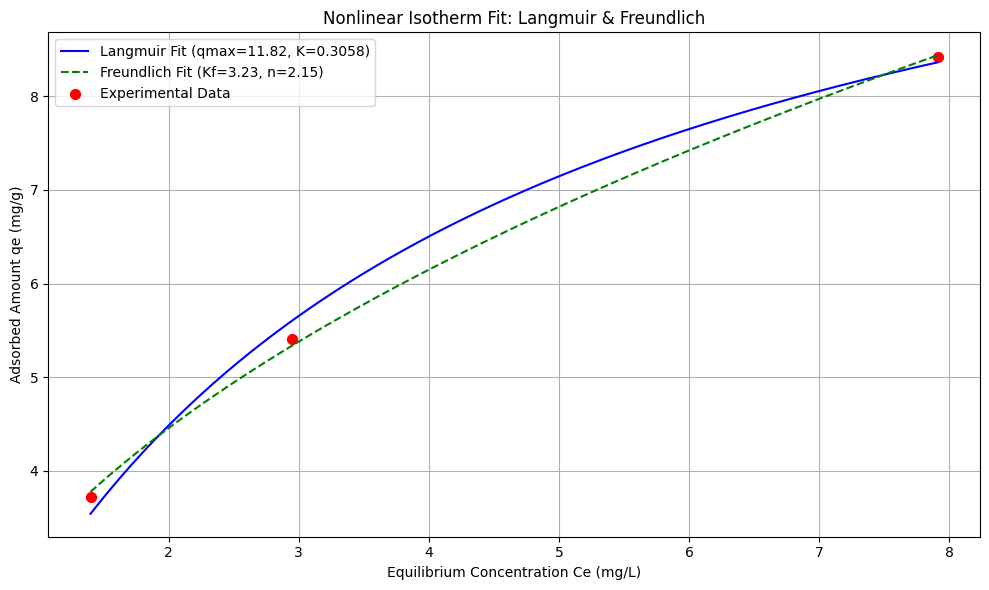


Nonlinear Fit Parameters:
Langmuir: q_max = 11.8186, K = 0.305822
Freundlich: Kf = 3.2314, n = 2.1548


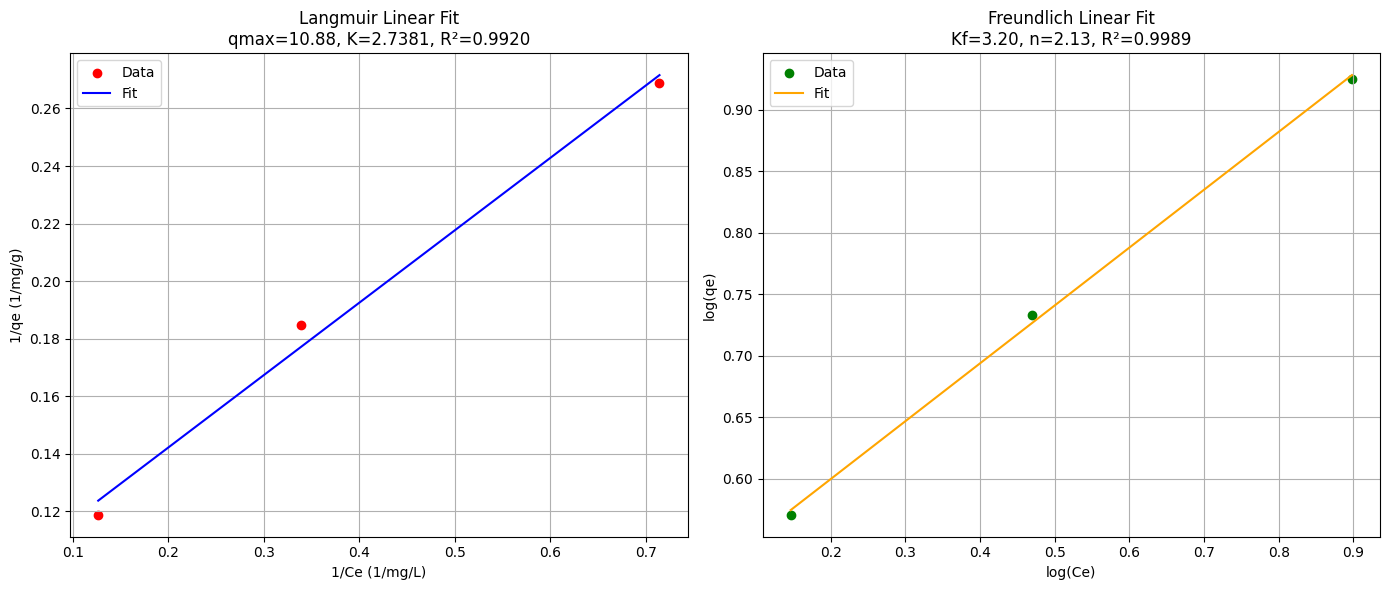

In [12]:
import numpy as np
import matplotlib.pyplot as ptt
import csv
from scipy.optimize import curve_fit
from scipy.stats import linregress
import pandas as pandas

#########csv--file
data = {
    "C0": [20, 30, 50],
    "Ce": [1.4, 2.95, 7.91],
    "V": [0.1]*3,
    "m": [0.5]*3
}
pandas.DataFrame(data).to_csv("experimental-data.csv", index=False)
##################################################################
# Langmuir model (nonlinear)
def langmuir_isotherm(C, q_max, K):
    return (q_max * K * C) / (1 + K * C)

# Freundlich model (nonlinear)
def freundlich_isotherm(C, Kf, n):
    return Kf * (C ** (1 / n))
##################################################################
# Read CSV and compute q-exp
def read_and_compute_qexp(filename):
    Ce_list = []
    q_exp_list = []
    with open(filename, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            C0 = float(row['C0'])
            Ce = float(row['Ce'])
            V = float(row['V'])   # in L
            m = float(row['m'])   # in g
            q = ((C0 - Ce) * V) / m
            Ce_list.append(Ce)
            q_exp_list.append(q)
    return np.array(Ce_list), np.array(q_exp_list)
############################################################
# Plot Linearized Langmuir & Freundlich
def plot_linearized_isotherms(C_exp, q_exp):
    # Langmuir: 1/qe vs 1/Ce
    x_lang = 1 / C_exp
    y_lang = 1 / q_exp
    slope_l, intercept_l, r_value_l, _, _ = linregress(x_lang, y_lang)
    q_max_lin = 1 / intercept_l
    K_lin = slope_l / intercept_l

    # Freundlich: log(qe) vs log(Ce)
    x_f = np.log10(C_exp)
    y_f = np.log10(q_exp)
    slope_f, intercept_f, r_value_f, _, _ = linregress(x_f, y_f)
    Kf_lin = 10 ** intercept_f
    n_lin = 1 / slope_f

    # Plotting
    fig, axs = ptt.subplots(1, 2, figsize=(14, 6))

    # Langmuir linear plot
    axs[0].scatter(x_lang, y_lang, color='red', label='Data')
    axs[0].plot(x_lang, intercept_l + slope_l * x_lang, color='blue', label='Fit')
    axs[0].set_xlabel('1/Ce (1/mg/L)')
    axs[0].set_ylabel('1/qe (1/mg/g)')
    axs[0].set_title(f'Langmuir Linear Fit\nqmax={q_max_lin:.2f}, K={K_lin:.4f}, R²={r_value_l**2:.4f}')
    axs[0].legend()
    axs[0].grid(True)

    # Freundlich linear plot
    axs[1].scatter(x_f, y_f, color='green', label='Data')
    axs[1].plot(x_f, intercept_f + slope_f * x_f, color='orange', label='Fit')
    axs[1].set_xlabel('log(Ce)')
    axs[1].set_ylabel('log(qe)')
    axs[1].set_title(f'Freundlich Linear Fit\nKf={Kf_lin:.2f}, n={n_lin:.2f}, R²={r_value_f**2:.4f}')
    axs[1].legend()
    axs[1].grid(True)

    ptt.tight_layout()
    ptt.savefig("linear_fits.png")
    ptt.show()
########################################################################
# Main plotting + nonlinear fitting
def plot_isotherms():
    # Load data
    C_exp, q_exp = read_and_compute_qexp("experimental-data.csv")

    # Nonlinear fit - Langmuir
    popt_langmuir, _ = curve_fit(langmuir_isotherm, C_exp, q_exp, bounds=(0, np.inf))
    q_max_fit, K_fit = popt_langmuir

    # Nonlinear fit - Freundlich
    popt_freundlich, _ = curve_fit(freundlich_isotherm, C_exp, q_exp, bounds=(0, np.inf))
    Kf_fit, n_fit = popt_freundlich

    # Generate smooth curves
    C_smooth = np.linspace(min(C_exp), max(C_exp), 500)
    q_langmuir = langmuir_isotherm(C_smooth, q_max_fit, K_fit)
    q_freundlich = freundlich_isotherm(C_smooth, Kf_fit, n_fit)

    # Plot nonlinear curves
    ptt.figure(figsize=(10, 6))
    ptt.plot(C_smooth, q_langmuir, label=f'Langmuir Fit (qmax={q_max_fit:.2f}, K={K_fit:.4f})', color='blue')
    ptt.plot(C_smooth, q_freundlich, label=f'Freundlich Fit (Kf={Kf_fit:.2f}, n={n_fit:.2f})', color='green', linestyle='--')
    ptt.scatter(C_exp, q_exp, label='Experimental Data', color='red', s=50)

    ptt.xlabel('Equilibrium Concentration Ce (mg/L)')
    ptt.ylabel('Adsorbed Amount qe (mg/g)')
    ptt.title('Nonlinear Isotherm Fit: Langmuir & Freundlich')
    ptt.legend()
    ptt.grid(True)
    ptt.tight_layout()
    ptt.savefig("nonlinear_fits.png")
    ptt.show()

    # Print nonlinear results
    print("\nNonlinear Fit Parameters:")
    print(f"Langmuir: q_max = {q_max_fit:.4f}, K = {K_fit:.6f}")
    print(f"Freundlich: Kf = {Kf_fit:.4f}, n = {n_fit:.4f}")

    # Linearized plots
    plot_linearized_isotherms(C_exp, q_exp)
######################################################################
# Run everything
if __name__ == "__main__":
    plot_isotherms()
